# AdaBoost

- Base 모델 아무거나 상관없음

In [2]:
warnings.simplefilter('ignore')
plt.rcParams['font.family'] = 'NanumGothic'

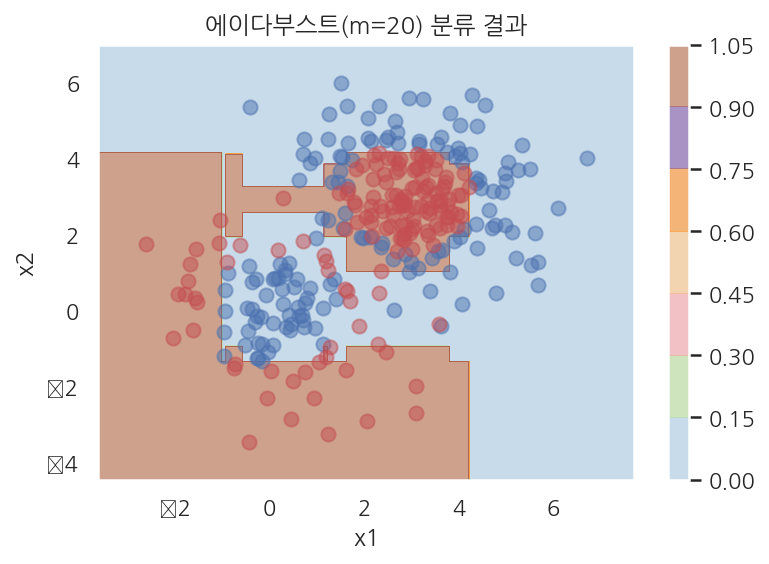

In [11]:
from sklearn.datasets import make_gaussian_quantiles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

X1, y1 = make_gaussian_quantiles(cov=2.,
                                 n_samples=100, n_features=2,
                                 n_classes=2, random_state=1)
X2, y2 = make_gaussian_quantiles(mean=(3, 3), cov=1.5,
                                 n_samples=200, n_features=2,
                                 n_classes=2, random_state=1)
X = np.concatenate((X1, X2))
y = np.concatenate((y1, - y2 + 1))

class MyAdaBoostClassifier(AdaBoostClassifier):
    
    def __init__(self,
                 base_estimator=None,
                 n_estimators=50,
                 learning_rate=1.,
                 algorithm='SAMME.R',
                 random_state=None):

        super(MyAdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state)
        self.sample_weight = [None] * n_estimators
        
    def _boost(self, iboost, X, y, sample_weight, random_state):
        sample_weight, estimator_weight, estimator_error = \
        super(MyAdaBoostClassifier, self)._boost(iboost, X, y, sample_weight, random_state)
        self.sample_weight[iboost] = sample_weight.copy()
        return sample_weight, estimator_weight, estimator_error
    
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=20)
model_ada.fit(X, y)

def plot_result(model, title="분류결과", legend=False, s=50):
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, 0.02), np.arange(x2_min, x2_max, 0.02))
    if isinstance(model, list):
        Y = model[0].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
        for i in range(len(model) - 1):
            Y += model[i + 1].predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    else:
        Y = model.predict(np.c_[xx1.ravel(), xx2.ravel()]).reshape(xx1.shape)
    cs = plt.contourf(xx1, xx2, Y, cmap=plt.cm.Paired, alpha=0.5)
    for i, n, c in zip(range(2), "01", "br"):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=c, s=s, alpha=0.5, label="Class %s" % n)
    plt.xlim(x1_min, x1_max)
    plt.ylim(x2_min, x2_max)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.colorbar(cs)
    if legend:
        plt.legend()
    plt.grid(False)

plot_result(model_ada, "에이다부스트(m=20) 분류 결과")

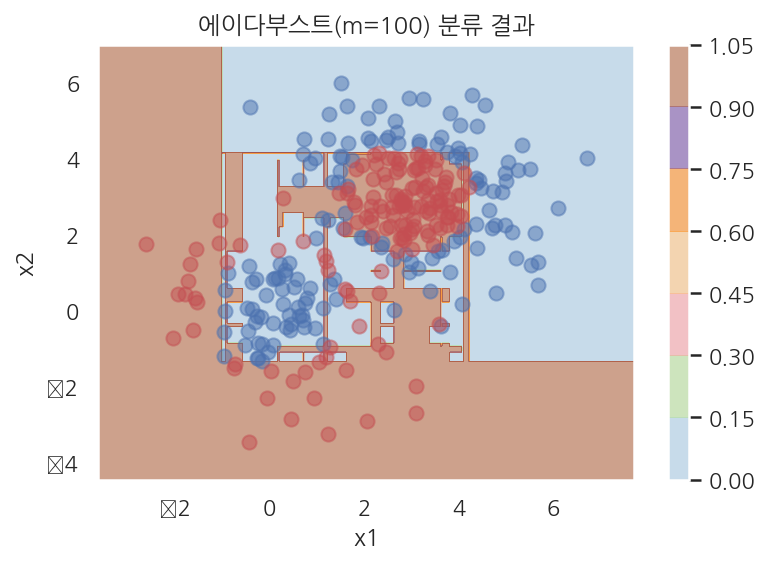

In [12]:
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0), n_estimators=100)
model_ada.fit(X, y)
plot_result(model_ada, "에이다부스트(m=100) 분류 결과")

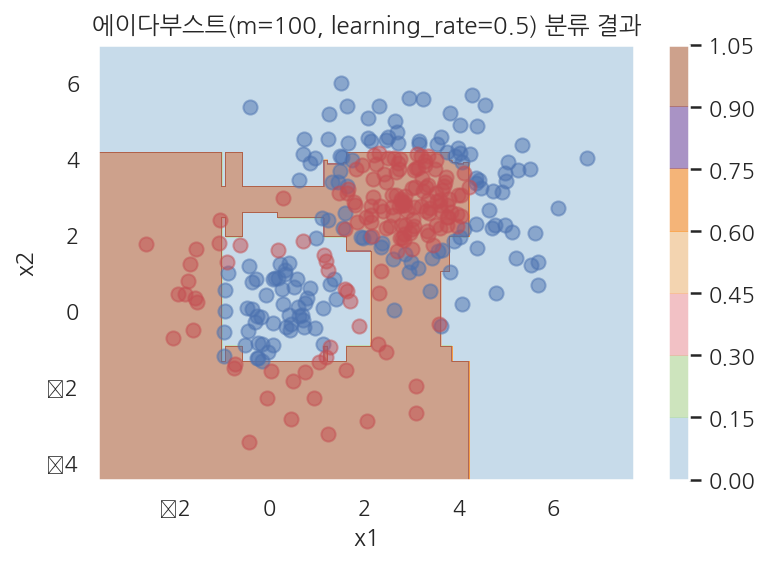

In [15]:
model_ada = MyAdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=0),learning_rate=0.3, n_estimators=100)
model_ada.fit(X, y)

plot_result(model_ada, "에이다부스트(m=100, learning_rate=0.5) 분류 결과")

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score

mean_test_accuracy = []
for n in np.arange(1, 1001, 100):
    model1 = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=n)
    mean_test_accuracy.append(cross_val_score(model1, X, y, cv=5).mean())

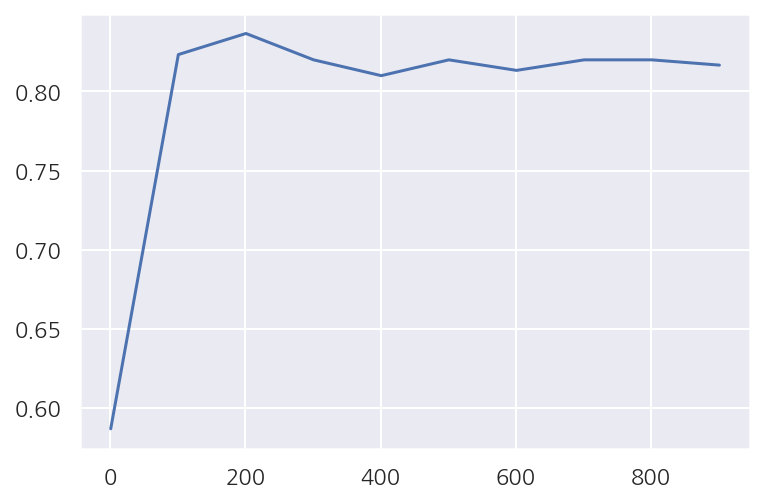

In [17]:
plt.plot(np.arange(1, 1000, 100), mean_test_accuracy)
plt.show()

# Gradient Boost

- DecisionTree 빼고는 못씀
- 회귀분석 원리로 작동하기 때문에 '회귀분석이 가능한' 분류기인 'Decision Tree'만 사용

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
model_grd = GradientBoostingClassifier(max_depth=2, n_estimators=100, random_state=0)

In [19]:
model_grd.fit(X,y)

GradientBoostingClassifier(max_depth=2, random_state=0)

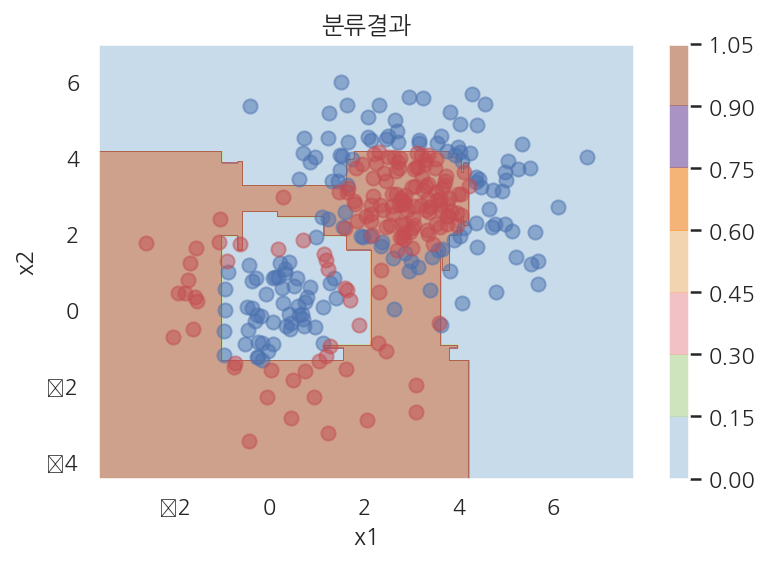

In [20]:
plot_result(model_grd)

# XGBoost 

- Drop Out 방식 사용 (정규화)
    - 멤버를 추가시킬 때마다, 전 멤버들 중 일부를 강제로 휴가보냄
        - 그럼 새로운 멤버는 전임자가 했던 일들'도' 추가로 해야됨
    - 이런식으로 멤버 수를 늘리면서 다양성을 줌

In [23]:
import xgboost

In [24]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=100, max_depth=1, random_state=0)
model.fit(X,y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

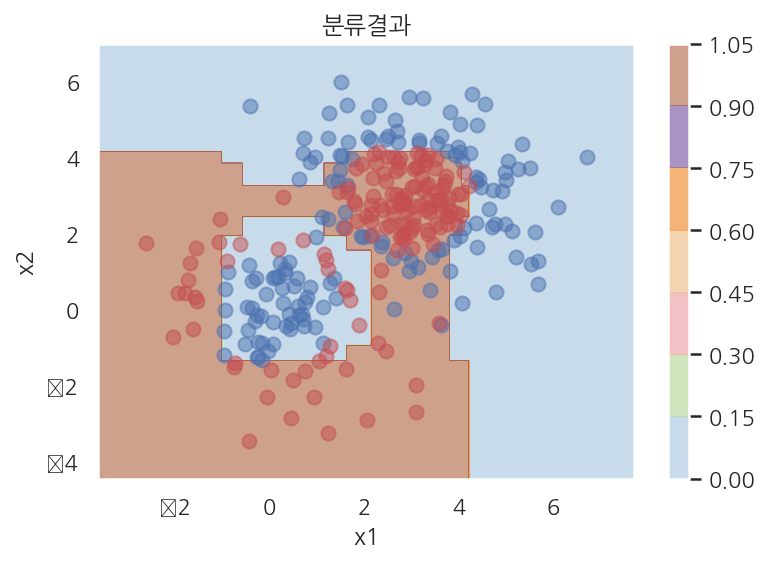

In [25]:
plot_result(model)

# LightGBM 라이브러리

- Drop Out 방식 사용
    - 멤버를 추가시킬 때마다, 전 멤버들 중 일부를 강제로 휴가보냄
        - 그럼 새로운 멤버는 전임자가 했던 일들'도' 추가로 해야됨
    - 이런식으로 멤버 수를 늘리면서 다양성을 줌

In [26]:
import lightgbm

model = lightgbm.LGBMClassifier(n_estimators=100, max_depth=1,random_state=0)
model.fit(X,y)

LGBMClassifier(max_depth=1, random_state=0)

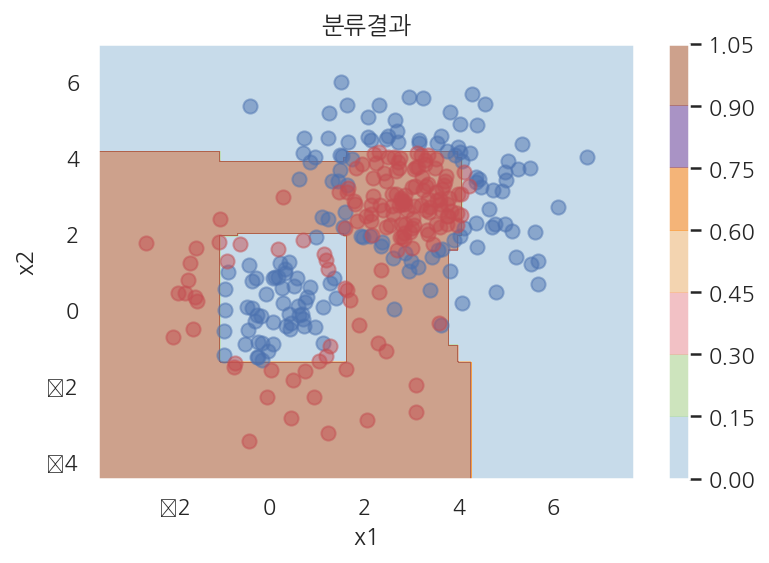

In [27]:
plot_result(model)